# ARXIV Scholar

In [12]:
import pandas as pd
import csv
import json
import ast
import requests
import matplotlib.pyplot as plt
from collections import OrderedDict
from collections import Counter
from operator import itemgetter
import graphics_parse as gp
import re
import unicodedata
import nltk
from nltk.corpus import stopwords


In [13]:
def text_clean(text: str):
    """
        Clean string
        Args:
            text (str): dataframe to apply the method
            wnl (WordNetLemmatizer): lemmatize words
    """
    stop_words = set(stopwords.words('english'))
    text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [nltk.stem.WordNetLemmatizer().lemmatize(word) for word in words if word not in stop_words]

In [14]:
def count_words(text):
  uniques = []
  for word in text:
    if word not in uniques:
      uniques.append(word)

  counts = []
  for unique in uniques:
    count = 0              
    for word in text:     
      if word == unique:  
        count += 1        
    counts.append((count, unique))

  counts.sort()         
  counts.reverse()  
  return counts     

In [35]:
# Clean dataset

def contains_number(string):
    return any(char.isdigit() for char in string)

with open('./data/arxivData.json', 'r') as dataset:
    papers = json.loads(dataset.read())

authors = set() # statistics purpose

for paper in papers:
    names = []

    # authors
    for author in ast.literal_eval(paper['author']):        
        names.append(author['name'])
        authors.add(author['name'])
    paper['authors'] = names

    # link
    for link in ast.literal_eval(paper['link']):
        if link['rel'] == 'alternate':
            paper['link'] = link['href']

    # date
    date = str(paper['year']) + '-' + str(paper['month']) + '-' +  str(paper['day']) 
    paper['date'] = date

    # tags
    tags = []
    for tag in ast.literal_eval(paper['tag']):
        if (contains_number(tag['term'])):
            continue
        tags.append(tag['term'])
    paper['tags'] = tags

    paper.pop('author')
    paper.pop('id')
    paper.pop('year')
    paper.pop('month')
    paper.pop('day')
    paper.pop('tag')

    # top words
    clean = text_clean(paper['summary'])
    paper['top_words'] = [word[1] for word in count_words(clean)[:10]]

In [36]:
def getTitle(tag):
    URL = 'https://arxiv.org/list/'
    url = URL + tag + '/recent'

    response = requests.get(url)
    text = response.text

    dlPageIndex = text.find("dlpage")

    h1Index = text.find("<h1>", dlPageIndex+1)
    h1FinalIndex = text.find("</h1>", h1Index)

    result = text[h1Index+4:h1FinalIndex-1]
    return result

tagsDict = {}

nReqs = 0

for paper in papers:
    urlTags = paper['tags']
    newTags = []
    
    for tag in urlTags:
        if tag not in tagsDict.keys():
            tagsDict[tag] = getTitle(tag)
            nReqs+=1
        
        newTags.append(tagsDict[tag])
    paper['tags'] = newTags

In [17]:
df = pd.DataFrame(papers)
df.to_csv('data/dateset.csv', index=False)  

In [18]:
df = pd.read_csv('data/dateset.csv')

Number of entries:  41000
Number of authors:  59888
Number of subjects:  161


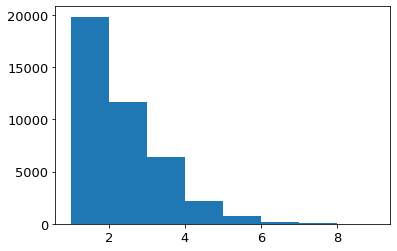

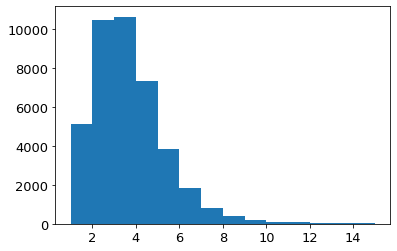

In [46]:
# Statistics

print("Number of entries: ", len(papers))

print("Number of authors: ", len(authors))

print("Number of subjects: ", nReqs)

subjectsFreq = []
authorsFreq = []

for paper in papers:
    subjectsFreq.append(len(paper['tags']))
    authorsFreq.append(len(paper['authors']))

plt.rcParams.update({'font.size': 13})

plt.hist(subjectsFreq, bins=[1,2,3,4,5,6,7,8,9])
plt.show()

plt.hist(authorsFreq, bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.show()

In [20]:
df.isnull().sum()

link       0
summary    0
title      0
authors    0
date       0
tags       0
dtype: int64

In [21]:
tags = {}
authors = {}
years = {}
for index, row in df.iterrows():

    # tags
    allTags = gp.splitString(row.tags)
    for tag in allTags:
        gp.checkExistance(tags, tag)

    # authors
    allAuthors = gp.splitString(row.authors)
    for author in allAuthors:
        gp.checkExistance(authors, author)

    # years
    gp.checkExistance(years, row.date[0:4])

In [22]:
# most relevant tags
tags['Others'] = 0
keys = []
for key in tags:
    if tags[key] < 3819:
        tags['Others'] += tags[key] 
    else:    
        keys.append(key)
tags = {key:tags[key] for key in tags if key in keys}

# top 10 authors
authors = dict(sorted(authors.items(), key= itemgetter(1), reverse=True)[:10])

# order years
years = OrderedDict(sorted(years.items()))

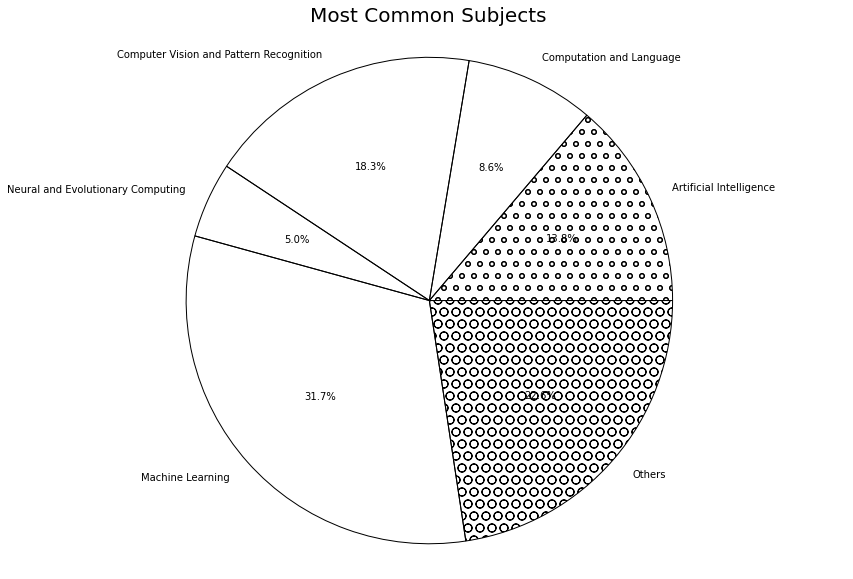

In [23]:
gp.piePlot(tags, 'Most Common Subjects', '../docs/res/tags.jpg')

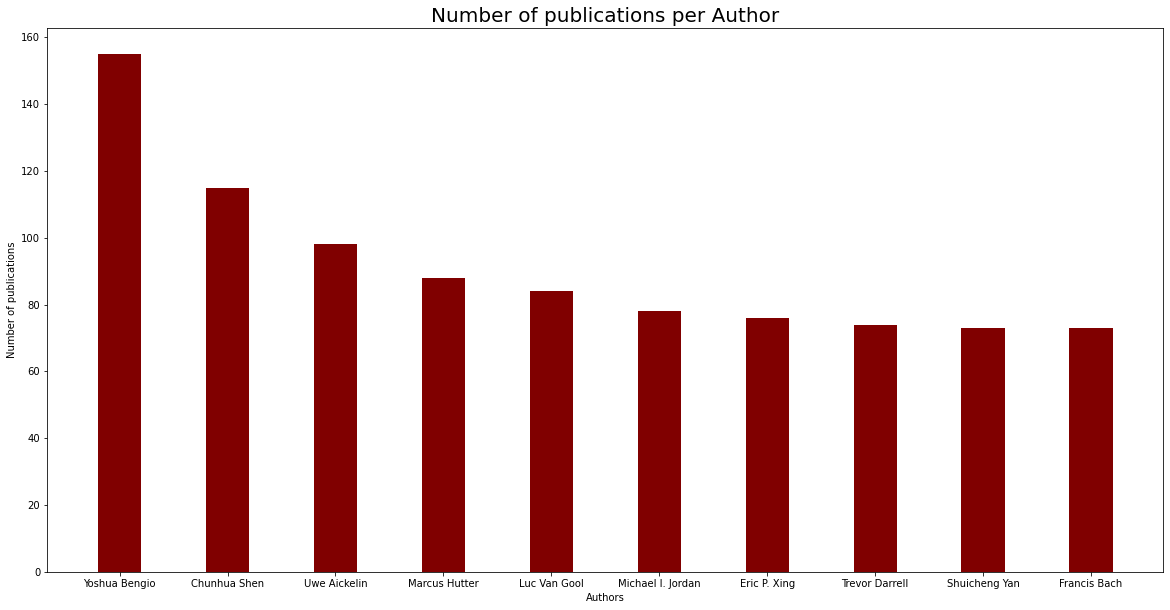

In [24]:
gp.barPlot(authors, 'Number of publications per Author', 'Authors', 'Number of publications', '../docs/res/pub_per_author.jpg')

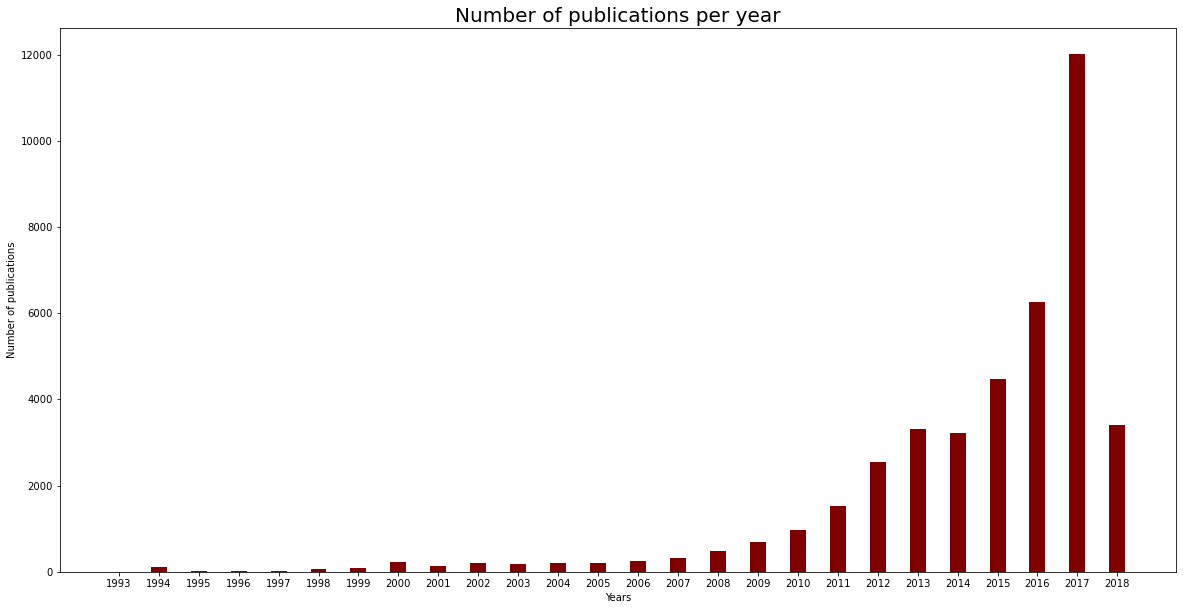

In [25]:
gp.barPlot(years, 'Number of publications per year', 'Years', 'Number of publications', '../docs/res/pub_per_year.jpg')